# Zillow Clustering Project

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import zscore, iqr, percentileofscore, scoreatpercentile

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import sklearn.metrics
import sklearn.linear_model

import wrangle_zillow as wr
import preprocessing as pr
import explore as ex

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

# Acquire
The DataFrame below contains all fields from the `properties_2017` table as well as the descriptive fields from the appropriate tables in the `zillow` database. The data is filtered to only include properties that have a `latitude` and `longitude` value.

In [2]:
df = wr.get_zillow_data()
print(f"Our DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Our DataFrame has 77580 rows and 68 columns.


id  parcelid  airconditioningtypeid  architecturalstyletypeid  \
0  1727539  14297519                    NaN                       NaN   
1  1387261  17052889                    NaN                       NaN   
2    11677  14186244                    NaN                       NaN   
3  2288172  12177905                    NaN                       NaN   
4  1970746  10887214                    1.0                       NaN   

   basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
0           NaN          3.5         4.0                  NaN   
1           NaN          1.0         2.0                  NaN   
2           NaN          2.0         3.0                  NaN   
3           NaN          3.0         4.0                  NaN   
4           NaN          3.0         3.0                  NaN   

   buildingqualitytypeid  calculatedbathnbr  decktypeid  \
0                    NaN                3.5         NaN   
1                    NaN                1.0         NaN   
2                    NaN                2.0         NaN   
3                    8.0                3.0         NaN   
4                    8.0                3.0         NaN   

   finishedfloor1squarefeet  calculatedfinishedsquarefeet  \
0                       NaN                        3100.0   
1                    1465.0                        1465.0   
2                       NaN                        1243.0   
3                       NaN                        2376.0   
4                       NaN                        1312.0   

   finishedsquarefeet12  finishedsquarefeet13  finishedsquarefeet15  \
0                3100.0                   NaN                   NaN   
1                1465.0                   NaN                   NaN   
2                1243.0                   NaN                   NaN   
3                2376.0                   NaN                   NaN   
4                1312.0                   NaN                   NaN   

   finishedsquarefeet50  finishedsquarefeet6    fips  fireplacecnt  \
0                   NaN                  NaN  6059.0           NaN   
1                1465.0                  NaN  6111.0           1.0   
2                   NaN                  NaN  6059.0           NaN   
3                   NaN                  NaN  6037.0           NaN   
4                   NaN                  NaN  6037.0           NaN   

   fullbathcnt  garagecarcnt  garagetotalsqft  hashottuborspa  \
0          3.0           2.0            633.0             NaN   
1          1.0           1.0              0.0             NaN   
2          2.0           2.0            440.0             NaN   
3          3.0           NaN              NaN             NaN   
4          3.0           NaN              NaN             NaN   

   heatingorsystemtypeid    latitude    longitude  lotsizesquarefeet  poolcnt  \
0                    NaN  33634931.0 -117869207.0             4506.0      NaN   
1                    NaN  34449266.0 -119281531.0            12647.0      NaN   
2                    NaN  33886168.0 -117823170.0             8432.0      1.0   
3                    2.0  34245180.0 -118240722.0            13038.0      1.0   
4                    2.0  34185120.0 -118414640.0           278581.0      1.0   

   poolsizesum  pooltypeid10  pooltypeid2  pooltypeid7  \
0          NaN           NaN          NaN          NaN   
1          NaN           NaN          NaN          NaN   
2          NaN           NaN          NaN          1.0   
3          NaN           NaN          NaN          1.0   
4          NaN           NaN          NaN          1.0   

  propertycountylandusecode  propertylandusetypeid propertyzoningdesc  \
0                       122                  261.0                NaN   
1                      1110                  261.0                NaN   
2                       122                  261.0                NaN   
3                      0101                  261.0         LCR110000*   
4               

> What kind of data types are we working with? How many null values are in each column?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77580 entries, 0 to 77579
Data columns (total 68 columns):
id                              77580 non-null int64
parcelid                        77580 non-null int64
airconditioningtypeid           25007 non-null float64
architecturalstyletypeid        207 non-null float64
basementsqft                    50 non-null float64
bathroomcnt                     77580 non-null float64
bedroomcnt                      77580 non-null float64
buildingclasstypeid             15 non-null float64
buildingqualitytypeid           49810 non-null float64
calculatedbathnbr               76964 non-null float64
decktypeid                      614 non-null float64
finishedfloor1squarefeet        6037 non-null float64
calculatedfinishedsquarefeet    77379 non-null float64
finishedsquarefeet12            73924 non-null float64
finishedsquarefeet13            42 non-null float64
finishedsquarefeet15            3027 non-null float64
finishedsquarefeet50          

> **We will need to address the abudance of null values and change some of the data types before we can begin our analysis.**

> Let's take a look at some of the summary statistics before we being preparing our data.

In [4]:
df.describe()

id      parcelid  airconditioningtypeid  \
count  7.758000e+04  7.758000e+04           25007.000000   
mean   1.495404e+06  1.300828e+07               1.812013   
std    8.609700e+05  3.519376e+06               2.965768   
min    3.490000e+02  1.071186e+07               1.000000   
25%    7.521430e+05  1.153820e+07               1.000000   
50%    1.498256e+06  1.253056e+07               1.000000   
75%    2.240950e+06  1.421135e+07               1.000000   
max    2.982274e+06  1.676893e+08              13.000000   

       architecturalstyletypeid  basementsqft   bathroomcnt    bedroomcnt  \
count                207.000000     50.000000  77580.000000  77580.000000   
mean                   7.386473    679.720000      2.298492      3.053222   
std                    2.728030    689.703546      0.996726      1.140472   
min                    2.000000     38.000000      0.000000      0.000000   
25%                    7.000000    273.000000      2.000000      2.000000   
50%                    7.000000    515.000000      2.000000      3.000000   
75%                    7.000000    796.500000      3.000000      4.000000   
max                   21.000000   3560.000000     18.000000     16.000000   

       buildingclasstypeid  buildingqualitytypeid  calculatedbathnbr  \
count            15.000000           49810.000000       76964.000000   
mean              3.933333               6.533728           2.316388   
std               0.258199               1.722082           0.979684   
min               3.000000               1.000000           1.000000   
25%               4.000000               6.000000           2.000000   
50%               4.000000               6.000000           2.000000   
75%               4.000000               8.000000           3.000000   
max               4.000000              12.000000          18.000000   

       decktypeid  finishedfloor1squarefeet  calculatedfinishedsquarefeet  \
count       614.0               6037.000000                  77379.000000   
mean         66.0               1366.165314                   1784.925923   
std           0.0                670.701336                    954.247864   
min          66.0                 44.000000                    128.000000   
25%          66.0                955.000000                   1182.000000   
50%          66.0               1257.000000                   1542.000000   
75%          66.0               1615.000000                   2112.000000   
max          66.0               6912.000000                  35640.000000   

       finishedsquarefeet12  finishedsquarefeet13  finishedsquarefeet15  \
count          73924.000000             42.000000           3027.000000   
mean            1760.274945           1388.761905           2354.491245   
std              934.349898            122.220874           1186.985442   
min              128.000000           1056.000000            598.000000   
25%             1172.000000           1344.000000           1624.000000   
50%             1523.000000           1440.000000           2088.000000   
75%             2075.000000           1440.000000           2831.000000   
max            21929.000000           1560.000000          35640.000000   

       finishedsquarefeet50  finishedsquarefeet6          fips  fireplacecnt  \
count           6037.000000           386.000000  77580.000000   8289.000000   
mean            1381.388935          2082.500000   6048.813998      1.191217   
std              725.792665          1240.382784     20.747162      0.490980   
min               44.000000           380.000000   6037.000000      1.000000   
25%              956.000000           993.750000   6037.000000      1.000000   
50%             1259.000000          1812.500000   6037.000000      1.000000   
75%             1621.000000          3053.500000   6059.000000      1.000000   
max            12467.000000          5598.000000   6111.000000      5.000000   

        fullbathcnt  garagecarcnt  garaget

> Finally, let's plot the distributions of the data to help us identify outliers that need to be addressed.

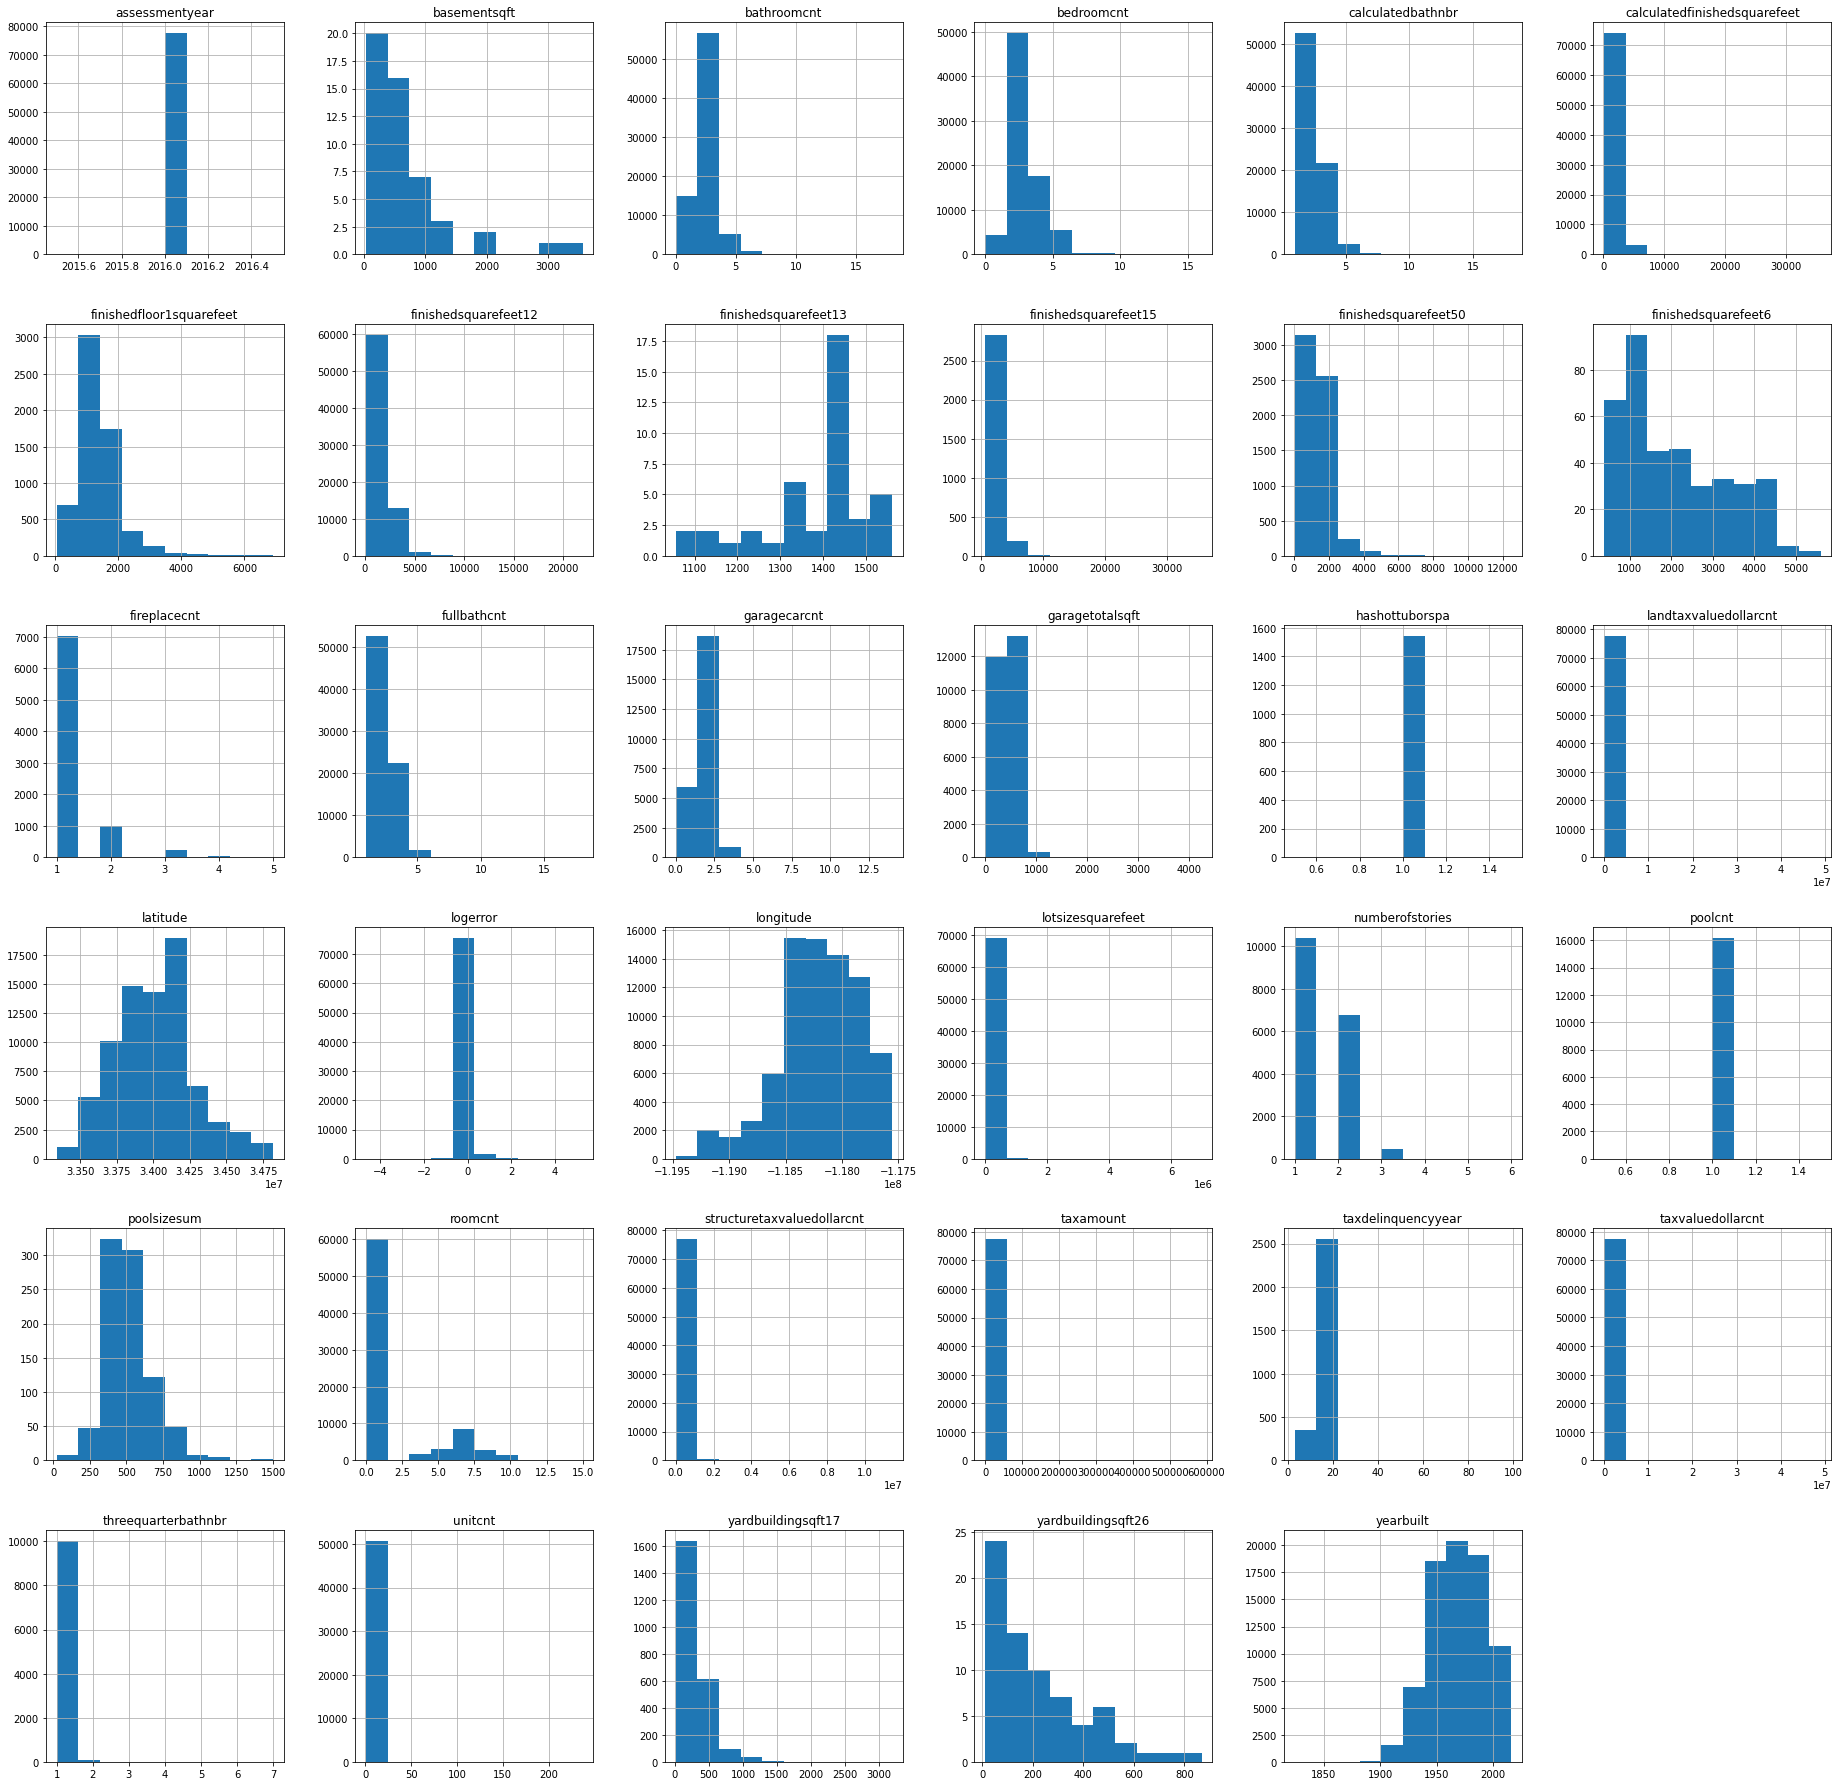

In [5]:
# let's drop the numeric id fields as they will not serve us in our hunt for outliers.
df.drop(columns=["id", "parcelid", "airconditioningtypeid", "architecturalstyletypeid", "buildingclasstypeid", "buildingqualitytypeid", "decktypeid", "fips", "heatingorsystemtypeid", "pooltypeid10", "pooltypeid2", "pooltypeid7", "propertylandusetypeid", "rawcensustractandblock", "regionidcity", "regionidcounty", "regionidneighborhood", "regionidzip", "storytypeid", "typeconstructiontypeid", "fireplaceflag", "censustractandblock"]).hist(figsize=(32, 32))
plt.show()

> **Now that we have a general idea of what our data looks like, let's move into preparation.**

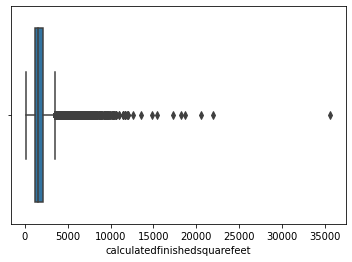

In [6]:
sns.boxplot(x=df.calculatedfinishedsquarefeet)

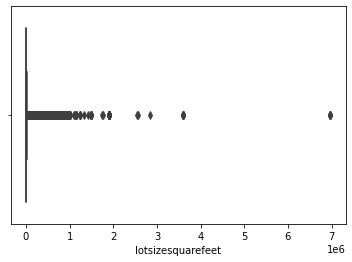

In [7]:
sns.boxplot(x=df.lotsizesquarefeet)

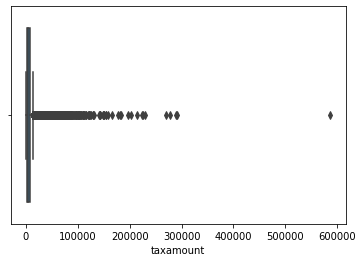

In [8]:
sns.boxplot(x=df.taxamount)

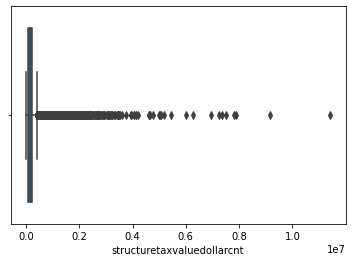

In [9]:
sns.boxplot(x=df.structuretaxvaluedollarcnt)

---
# Prepare

## Explanation of `prep_zillow` function
The function does the following:
1. Removes any properties that cannot be interpreted as single unit/single family homes
2. Removes fields that will not add any value to our analysis (i.e., identifier fields and those with redundant information)
3. Drops columns and indices that are missing more than 60% of their respective data
4. Imputes missing values remaining after the function in number 3 has been called (excluding the `regionidcity` field)
5. Drops indices deemed unworthy of imputation either because there are too few values missing to put in the effort of imputing or imputation is not a practical means of handling the missing data (e.g., `censustractandblock`)
6. Creates new `county` and `tax_rate` variables
7. Detects and removes outliers
8. Resets the index of the DataFrame
9. Drops former index column

In [10]:
df = wr.prep_zillow(df)
print(df.shape)
df.head()

(44768, 31)


parcelid  bathroomcnt  bedroomcnt  buildingqualitytypeid  \
0  14297519          3.5         4.0                    6.0   
1  17052889          1.0         2.0                    6.0   
2  14186244          2.0         3.0                    6.0   
3  12177905          3.0         4.0                    8.0   
4  12069064          1.0         2.0                    5.0   

   calculatedbathnbr  calculatedfinishedsquarefeet    fips  fullbathcnt  \
0                3.5                        3100.0  6059.0          3.0   
1                1.0                        1465.0  6111.0          1.0   
2                2.0                        1243.0  6059.0          2.0   
3                3.0                        2376.0  6037.0          3.0   
4                1.0                         738.0  6037.0          1.0   

     latitude    longitude  lotsizesquarefeet propertycountylandusecode  \
0  33634931.0 -117869207.0             4506.0                       122   
1  34449266.0 -119281531.0            12647.0                      1110   
2  33886168.0 -117823170.0             8432.0                       122   
3  34245180.0 -118240722.0            13038.0                      0101   
4  34149214.0 -118239357.0             4214.0                      0100   

   rawcensustractandblock  regionidcity  regionidcounty  regionidzip  roomcnt  \
0            6.059063e+07       53571.0          1286.0      96978.0      0.0   
1            6.111001e+07       13091.0          2061.0      97099.0      5.0   
2            6.059022e+07       21412.0          1286.0      97078.0      6.0   
3            6.037300e+07      396551.0          3101.0      96330.0      0.0   
4            6.037302e+07       45457.0          3101.0      96325.0      0.0   

   unitcnt  yearbuilt  structuretaxvaluedollarcnt  taxvaluedollarcnt  \
0      1.0     1998.0                    485713.0          1023282.0   
1      1.0     1967.0                     88000.0           464000.0   
2      1.0     1962.0                     85289.0           564778.0   
3      1.0     1970.0                    108918.0           145143.0   
4      1.0     1922.0                     18890.0           218552.0   

   assessmentyear  landtaxvaluedollarcnt  taxamount  censustractandblock  \
0          2016.0               537569.0   11013.72         6.059063e+13   
1          2016.0               376000.0    5672.48         6.111001e+13   
2          2016.0               479489.0    6488.30         6.059022e+13   
3          2016.0                36225.0    1777.51         6.037300e+13   
4          2016.0               199662.0    2366.08         6.037302e+13   

   logerror transactiondate heatingorsystemdesc        propertylandusedesc  \
0  0.025595      2017-01-01                None  Single Family Residential   
1  0.055619      2017-01-01                None  Single Family Residential   
2  0.005383      2017-01-01                None  Single Family Residential   
3 -0.103410      2017-01-01             Central  Single Family Residential   
4  0.101723      2017-01-01                None  Single Family Residential   

               county  tax_rate  
0       Orange County  0.010763  
1      Ventura County  0.012225  
2       Orange County  0.011488  
3  Los Angeles County  0.012247  
4  Los Angeles County  0.010826

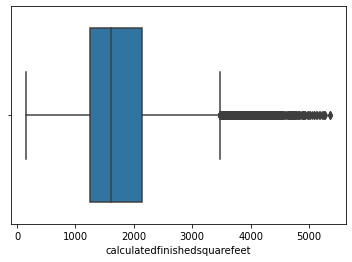

In [11]:
sns.boxplot(x=df.calculatedfinishedsquarefeet)

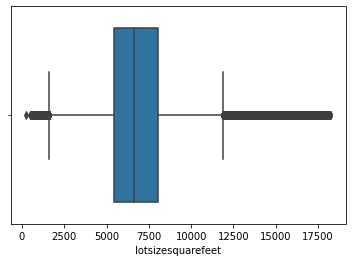

In [12]:
sns.boxplot(x=df.lotsizesquarefeet)

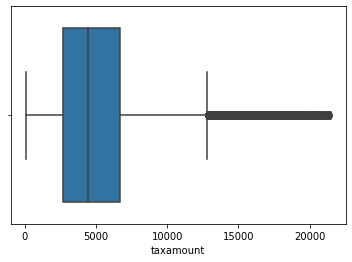

In [13]:
sns.boxplot(x=df.taxamount)

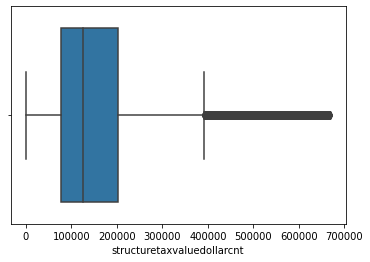

In [14]:
sns.boxplot(x=df.structuretaxvaluedollarcnt)

## Preprocessing

### Explanation of `split_impute_scale` function
The function does the following:
1. Splits prepared DataFrame into `train`, `validate`, and `test`
2. KNN imputes the regionidcity for `train`, `validate`, and `test`
3. Scales all appropriate numeric fields for `train`, `validate`, and `test`
4. Returns the `imputer`, `scaler`, `train`, `validate`, and `test` variables

In [15]:
imputer, scaler, train, validate, test = pr.split_impute_scale(df)
imputer

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=5, weights='uniform')

In [16]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [17]:
print(f"   train shape = {train.shape}")
print(f"validate shape = {validate.shape}")
print(f"    test shape = {test.shape}")

   train shape = (26860, 31)
validate shape = (8954, 31)
    test shape = (8954, 31)


In [18]:
train.head()

parcelid  bathroomcnt  bedroomcnt  buildingqualitytypeid  \
7087   0.008712          0.6    0.333333               0.636364   
33075  0.024432          0.3    0.500000               0.454545   
35427  0.012888          0.2    0.333333               0.454545   
7886   0.023362          0.2    0.666667               0.454545   
33404  0.011850          0.2    0.333333               0.272727   

       calculatedbathnbr  calculatedfinishedsquarefeet  fips  fullbathcnt  \
7087                 0.6                      0.522165  6037          0.6   
33075                0.3                      0.439455  6059          0.2   
35427                0.2                      0.224909  6037          0.2   
7886                 0.2                      0.274803  6059          0.2   
33404                0.2                      0.206102  6037          0.2   

       latitude  longitude  lotsizesquarefeet propertycountylandusecode  \
7087   0.565118   0.606294           0.425179                      0100   
33075  0.103840   0.918736           0.304955                       122   
35427  0.362500   0.556033           0.327198                      0100   
7886   0.271350   0.816511           0.348273                       122   
33404  0.336733   0.693832           0.315187                      0100   

       rawcensustractandblock regionidcity regionidcounty regionidzip  \
7087                 0.001178        12447           3101       96008   
33075                0.296872        17686           1286       96961   
35427                0.007435        54722           3101       96161   
7886                 0.297302        47568           1286       97004   
33404                0.006402        46298           3101       96247   

        roomcnt  unitcnt  yearbuilt  structuretaxvaluedollarcnt  \
7087   0.000000      0.0   0.430657                    0.696794   
33075  0.666667      0.0   0.700730                    0.294626   
35427  0.000000      0.0   0.591241                    0.179050   
7886   0.666667      0.0   0.613139                    0.108010   
33404  0.000000      0.0   0.554745                    0.163887   

       taxvaluedollarcnt  assessmentyear  landtaxvaluedollarcnt  taxamount  \
7087            0.361819             0.0               0.155282   0.396783   
33075           0.164664             0.0               0.085796   0.193285   
35427           0.355638             0.0               0.394432   0.360944   
7886            0.285909             0.0               0.335843   0.296881   
33404           0.171555             0.0               0.157402   0.181603   

       censustractandblock  logerror transactiondate heatingorsystemdesc  \
7087              0.000002  0.594238      2017-02-26             Central   
33075             0.000519  0.598979      2017-07-14                None   
35427             0.000013  0.606580      2017-07-27             Central   
7886              0.000520  0.602900      2017-03-02                None   
33404             0.000011  0.599040      2017-07-18             Central   

             propertylandusedesc              county  tax_rate  
7087   Single Family Residential  Los Angeles County  0.477314  
33075  Single Family Residential       Orange County  0.527775  
35427  Single Family Residential  Los Angeles County  0.411598  
7886   Single Family Residential       Orange County  0.428522  
33404  Single Family Residential  Los Angeles County  0.438077

In [19]:
train.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [20]:
validate.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [21]:
test.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26860 entries, 7087 to 43258
Data columns (total 31 columns):
parcelid                        26860 non-null float64
bathroomcnt                     26860 non-null float64
bedroomcnt                      26860 non-null float64
buildingqualitytypeid           26860 non-null float64
calculatedbathnbr               26860 non-null float64
calculatedfinishedsquarefeet    26860 non-null float64
fips                            26860 non-null object
fullbathcnt                     26860 non-null float64
latitude                        26860 non-null float64
longitude                       26860 non-null float64
lotsizesquarefeet               26860 non-null float64
propertycountylandusecode       26860 non-null object
rawcensustractandblock          26860 non-null float64
regionidcity                    26860 non-null object
regionidcounty                  26860 non-null object
regionidzip                     26860 non-null object
roomcnt      

In [23]:
train.describe()

parcelid   bathroomcnt    bedroomcnt  buildingqualitytypeid  \
count  26860.000000  26860.000000  26860.000000           26860.000000   
mean       0.015032      0.236046      0.374473               0.459852   
std        0.014177      0.164890      0.146786               0.113863   
min        0.000000      0.000000      0.000000               0.000000   
25%        0.005746      0.200000      0.333333               0.454545   
50%        0.012848      0.200000      0.333333               0.454545   
75%        0.022527      0.400000      0.500000               0.454545   
max        1.000000      1.000000      1.000000               1.000000   

       calculatedbathnbr  calculatedfinishedsquarefeet   fullbathcnt  \
count       26860.000000                  26860.000000  26860.000000   
mean            0.236050                      0.310549      0.223313   
std             0.164883                      0.136244      0.161040   
min             0.000000                      0.000000      0.000000   
25%             0.200000                      0.211092      0.200000   
50%             0.200000                      0.278641      0.200000   
75%             0.400000                      0.381884      0.400000   
max             1.000000                      1.000000      1.000000   

           latitude     longitude  lotsizesquarefeet  rawcensustractandblock  \
count  26860.000000  26860.000000       26860.000000            26860.000000   
mean       0.482954      0.654777           0.378082                0.170652   
std        0.190042      0.194574           0.156610                0.281672   
min        0.000000      0.000000           0.000000                0.000000   
25%        0.347628      0.543558           0.289940                0.004047   
50%        0.477606      0.678740           0.353890                0.006752   
75%        0.608153      0.798081           0.433076                0.296872   
max        1.000000      1.000000           1.000000                1.000000   

            roomcnt  unitcnt     yearbuilt  structuretaxvaluedollarcnt  \
count  26860.000000  26860.0  26860.000000                26860.000000   
mean       0.164600      0.0      0.614290                    0.234381   
std        0.262983      0.0      0.163092                    0.170998   
min        0.000000      0.0      0.000000                    0.000000   
25%        0.000000      0.0      0.525547                    0.114485   
50%        0.000000      0.0      0.598540                    0.186915   
75%        0.416667      0.0      0.722628                    0.302963   
max        1.000000      0.0      1.000000                    1.000000   

       taxvaluedollarcnt  assessmentyear  landtaxvaluedollarcnt     taxamount  \
count       26860.000000         26860.0           26860.000000  26860.000000   
mean            0.220531             0.0               0.188713      0.237612   
std             0.163463             0.0               0.165030      0.164188   
min             0.000000             0.0               0.000000      0.000000   
25%             0.100043             0.0               0.059152      0.121235   
50%             0.189073             0.0               0.151363      0.205797   
75%             0.297483             0.0               0.269833      0.310181   
max             1.000000             0.0               1.000000      1.000000   

       censustractandblock      logerror      tax_rate  
count         26860.000000  26860.000000  26860.000000  
mean              0.000336      0.596589      0.503073  
std               0.006120      0.021423      0.141609  
min               0.000000      0.000000      0.000000  
25%               0.000007      0.591399      0.418841  
50%               0.000012      0.595238      0.466601  
75%               0.000519      0.599258      0.549912  
max               1.000000      1.000000      1.000000

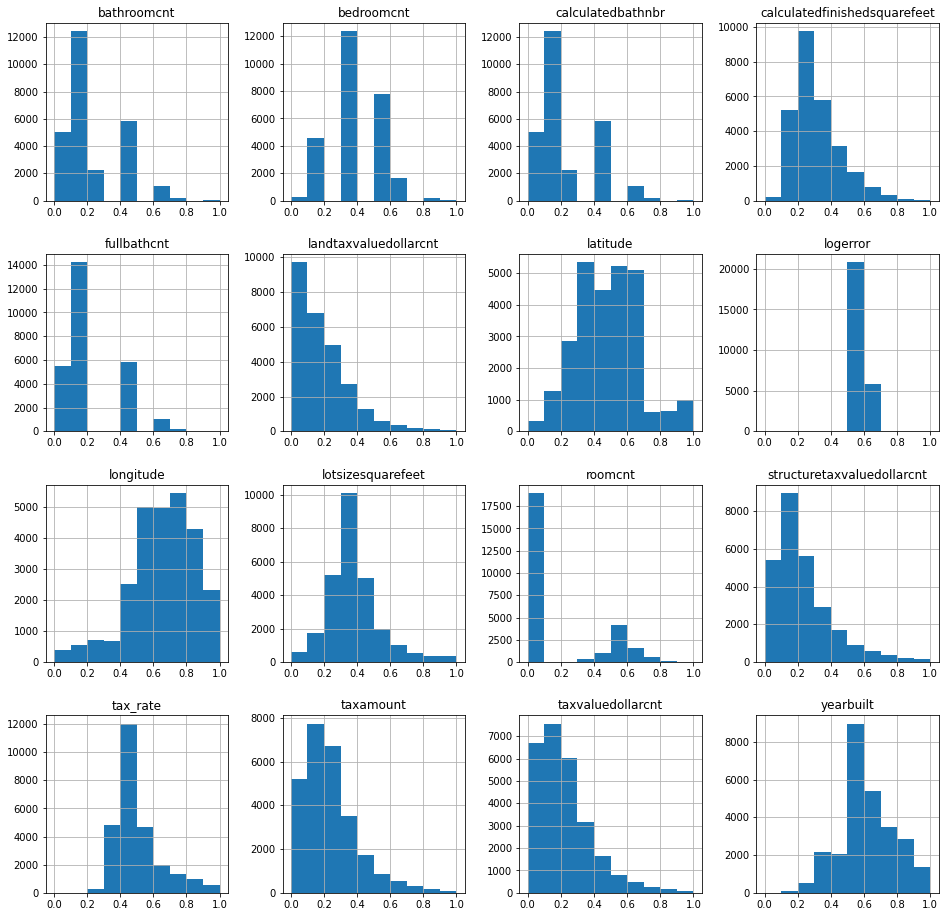

In [24]:
train = wr.convert_dtypes(train, columns=["parcelid", "buildingqualitytypeid", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock"], dtype="object")
train.hist(figsize=(16, 16))
plt.show()

# Explore

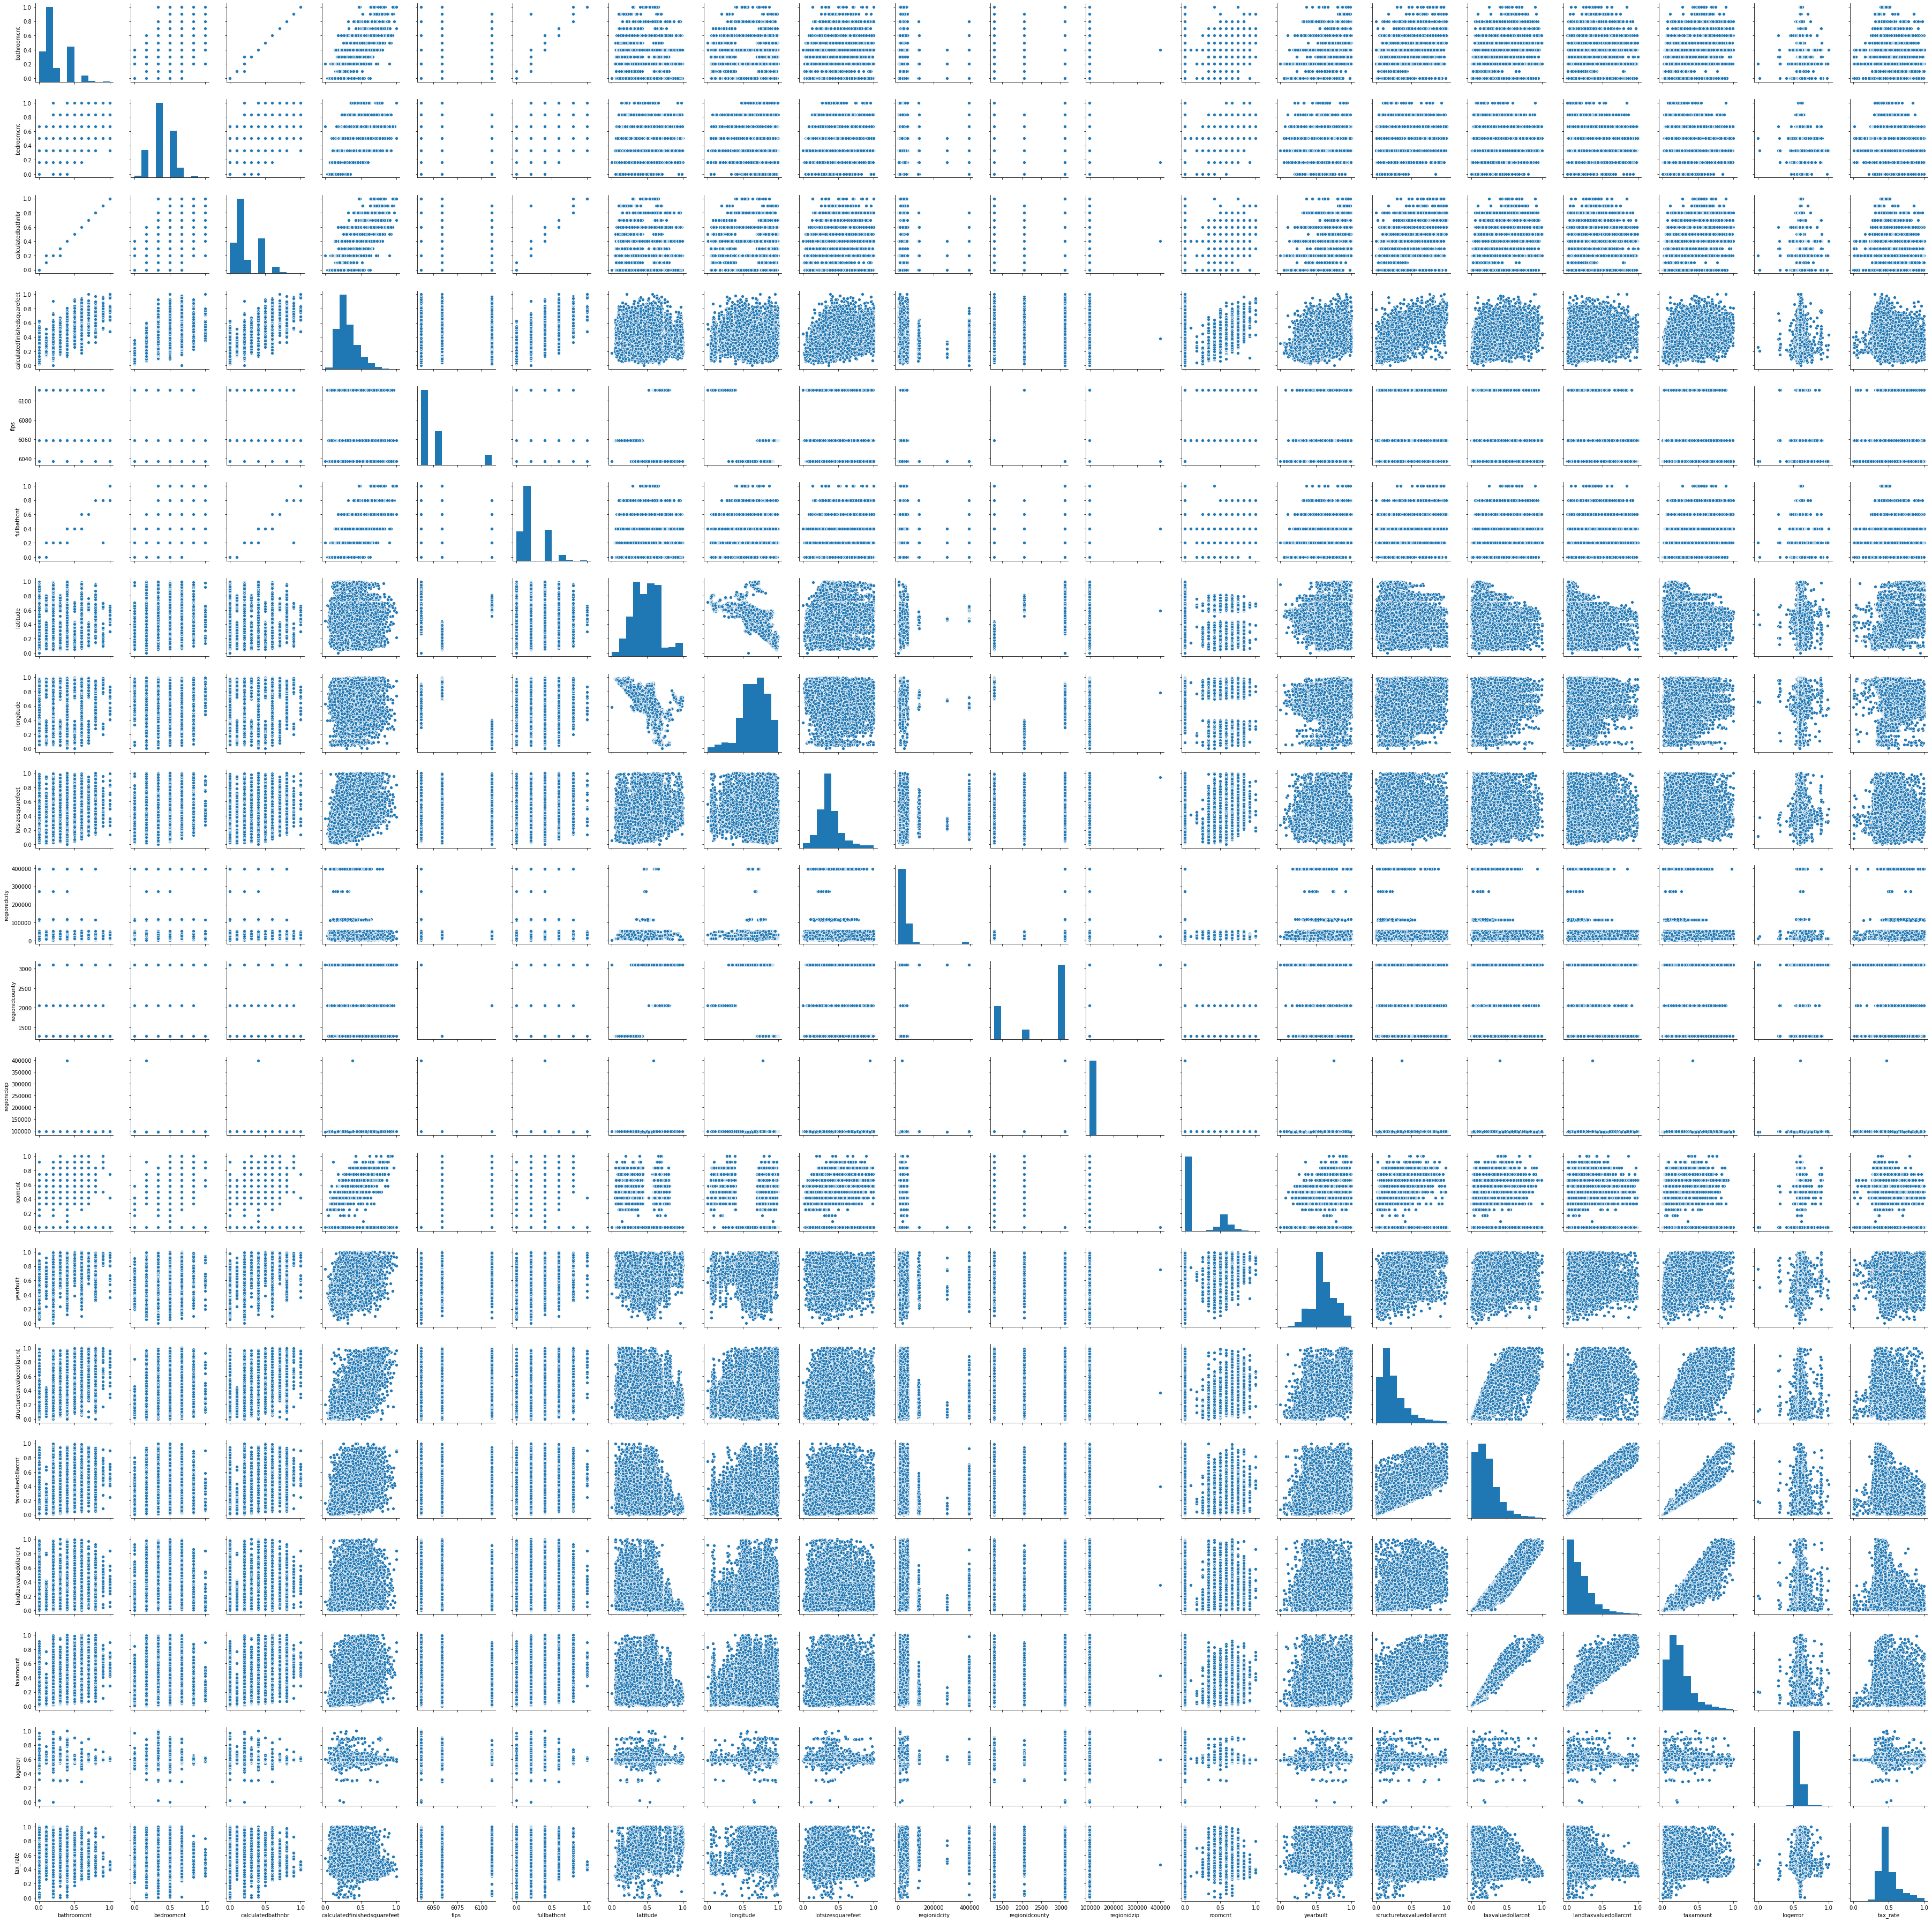

In [25]:
sns.pairplot(data=train.drop(columns=["parcelid", "buildingqualitytypeid", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock"]))

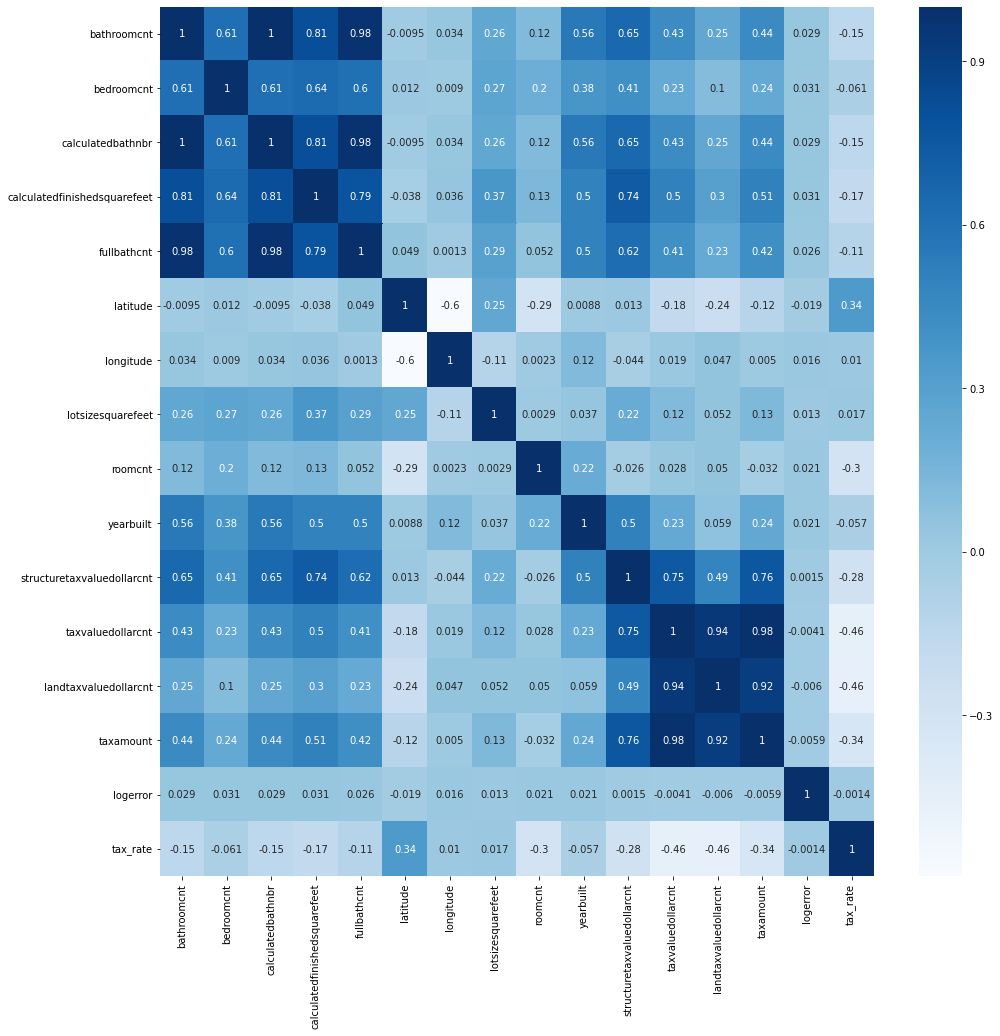

In [26]:
plt.figure(figsize=(16, 16))
sns.heatmap(train.corr(), annot=True, cmap="Blues")
plt.show()

## Cluster the Target Variable
Objectives:
1. Reduce the noise of the continuous variable so that trends in the data are more easily identifiable
2. Compare clusters with other variables through visualizations or hypothesis testing

In [27]:
X = train[["logerror"]]

In [28]:
# inital intuition of 6 clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
kmeans.predict(X)

array([5, 5, 0, ..., 0, 5, 5], dtype=int32)

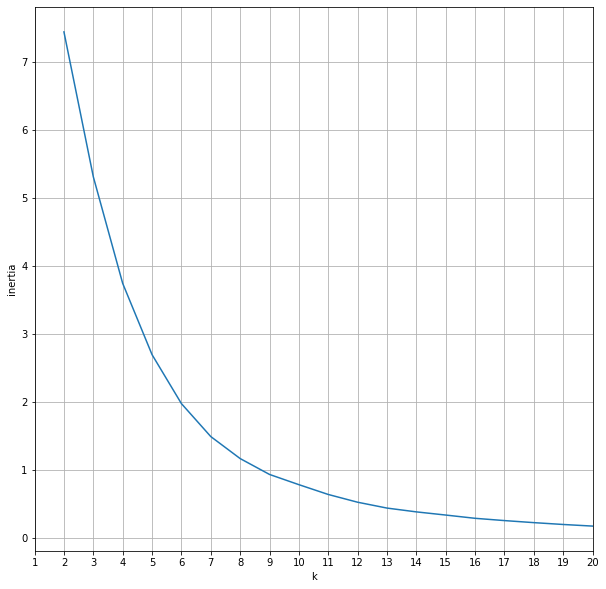

In [29]:
plt.figure(figsize=(10, 10))
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

> **6 or 7 seem like reasonable values for k**

In [30]:
# according to the elbow method above 7 clusters also seems reasonable
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
train["cluster_target"] = kmeans.predict(X)
train.head()

parcelid  bathroomcnt  bedroomcnt buildingqualitytypeid  \
7087   0.00871232          0.6    0.333333              0.636364   
33075   0.0244317          0.3    0.500000              0.454545   
35427   0.0128877          0.2    0.333333              0.454545   
7886    0.0233621          0.2    0.666667              0.454545   
33404   0.0118498          0.2    0.333333              0.272727   

       calculatedbathnbr  calculatedfinishedsquarefeet  fips  fullbathcnt  \
7087                 0.6                      0.522165  6037          0.6   
33075                0.3                      0.439455  6059          0.2   
35427                0.2                      0.224909  6037          0.2   
7886                 0.2                      0.274803  6059          0.2   
33404                0.2                      0.206102  6037          0.2   

       latitude  longitude  lotsizesquarefeet propertycountylandusecode  \
7087   0.565118   0.606294           0.425179                      0100   
33075  0.103840   0.918736           0.304955                       122   
35427  0.362500   0.556033           0.327198                      0100   
7886   0.271350   0.816511           0.348273                       122   
33404  0.336733   0.693832           0.315187                      0100   

      rawcensustractandblock regionidcity regionidcounty regionidzip  \
7087              0.00117839        12447           3101       96008   
33075               0.296872        17686           1286       96961   
35427             0.00743483        54722           3101       96161   
7886                0.297302        47568           1286       97004   
33404             0.00640242        46298           3101       96247   

        roomcnt unitcnt  yearbuilt  structuretaxvaluedollarcnt  \
7087   0.000000       0   0.430657                    0.696794   
33075  0.666667       0   0.700730                    0.294626   
35427  0.000000       0   0.591241                    0.179050   
7886   0.666667       0   0.613139                    0.108010   
33404  0.000000       0   0.554745                    0.163887   

       taxvaluedollarcnt assessmentyear  landtaxvaluedollarcnt  taxamount  \
7087            0.361819              0               0.155282   0.396783   
33075           0.164664              0               0.085796   0.193285   
35427           0.355638              0               0.394432   0.360944   
7886            0.285909              0               0.335843   0.296881   
33404           0.171555              0               0.157402   0.181603   

      censustractandblock  logerror transactiondate heatingorsystemdesc  \
7087          2.06058e-06  0.594238      2017-02-26             Central   
33075         0.000519124  0.598979      2017-07-14                None   
35427         1.30009e-05  0.606580      2017-07-27             Central   
7886          0.000519875  0.602900      2017-03-02                None   
33404         1.11955e-05  0.599040      2017-07-18             Central   

             propertylandusedesc              county  tax_rate  cluster_target  
7087   Single Family Residential  Los Angeles County  0.477314               0  
33075  Single Family Residential       Orange County  0.527775               0  
35427  Single Family Residential  Los Angeles County  0.411598               0  
7886   Single Family Residential       Orange County  0.428522               0  
33404  Single Family Residential  Los Angeles County  0.438077               0

In [31]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

logerror
0  0.596424
1  0.686231
2  0.873262
3  0.260132
4  0.620691
5  0.583017
6  0.529708

In [32]:
train.groupby("cluster_target")["logerror"].mean()

cluster_target
0    0.596440
1    0.686368
2    0.873262
3    0.260132
4    0.620749
5    0.583065
6    0.529708
Name: logerror, dtype: float64

> **There are two centroids for lower (0.29) and upper (0.85) outlier clusters. Generally, the centriods fall in between 0.51 and 0.65 indicating that most of the clusters are grouped close together**

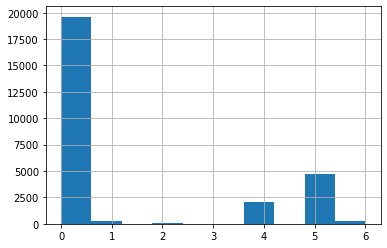

In [33]:
train.cluster_target.hist()

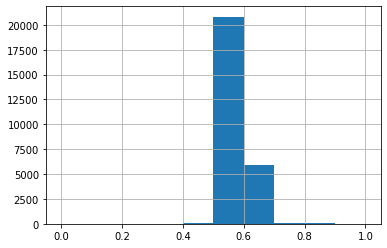

In [34]:
train.logerror.hist()

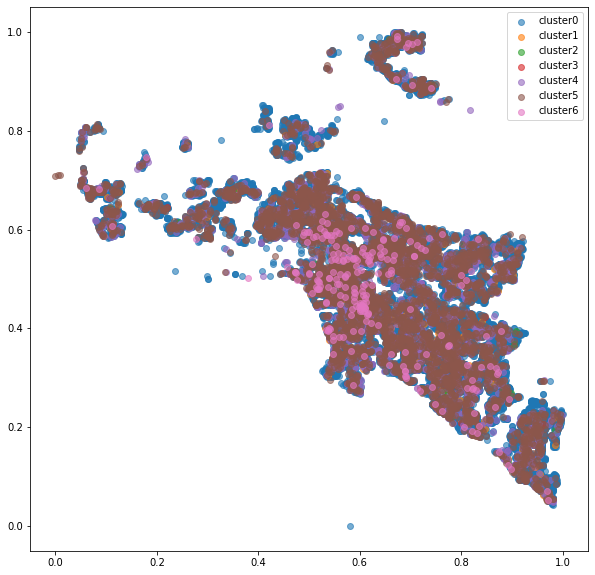

In [35]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("cluster_target"):
    plt.scatter(subset.longitude, subset.latitude, label="cluster" + str(cluster), alpha=.6)

plt.legend()

> **This visualization leads me to believe that the mean logerror by county is the same.**

$H_0$: The mean logerror by county is the same

$H_0$: The mean logerror by county is different

In [36]:
alpha = .001

la = train[train.county == "Los Angeles County"].logerror
orange = train[train.county == "Orange County"].logerror
ventura = train[train.county == "Ventura County"].logerror

f, p = stats.f_oneway(la, orange, ventura)
print(f"statistic = {f}")
print(f"  p-value = {p}")
print()
if p < alpha:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

statistic = 9.540220988687945
  p-value = 7.214491970949719e-05

Reject null hypothesis


## Cluster Independent Variables

In [37]:
X = train[["latitude", "longitude"]]

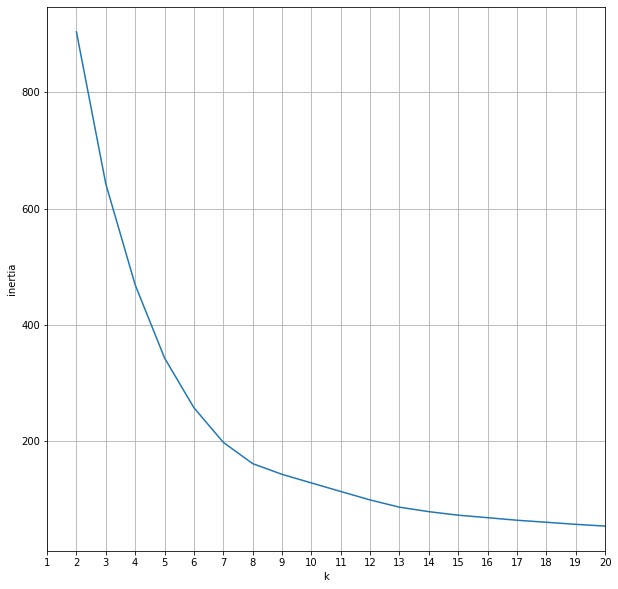

In [38]:
plt.figure(figsize=(10, 10))
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [39]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
train["location_cluster"] = kmeans.predict(X)

In [40]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

latitude  longitude
0  0.648797   0.496256
1  0.182128   0.921621
2  0.342456   0.781324
3  0.652747   0.204343
4  0.426674   0.594690
5  0.536390   0.761150
6  0.942691   0.677958

In [41]:
train.groupby("location_cluster")["latitude", "longitude"].mean()

latitude  longitude
location_cluster                     
0                 0.648667   0.496427
1                 0.181966   0.921776
2                 0.342218   0.781557
3                 0.652697   0.204487
4                 0.426429   0.594958
5                 0.536297   0.761173
6                 0.942691   0.677958

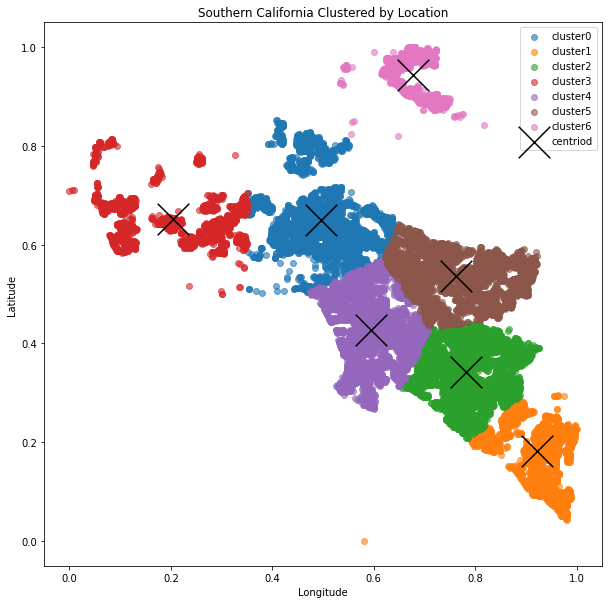

In [42]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("location_cluster"):
    plt.scatter(subset.longitude, subset.latitude, label="cluster" + str(cluster), alpha=.6)

centriods.plot.scatter(x="longitude", y="latitude", c="black", marker="x", s=1000, ax=plt.gca(), label="centriod")    

plt.legend()
plt.title("Southern California Clustered by Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [43]:
X = train[["calculatedfinishedsquarefeet", "lotsizesquarefeet"]]

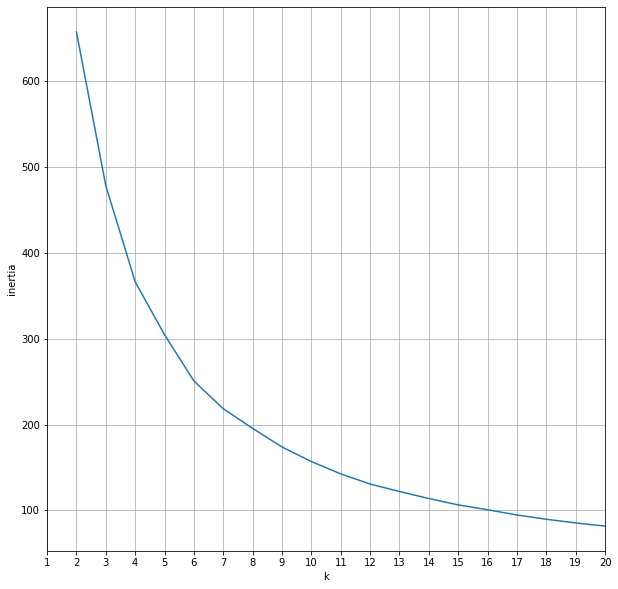

In [44]:
plt.figure(figsize=(10, 10))
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [45]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
train["size_cluster"] = kmeans.predict(X)

In [46]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

calculatedfinishedsquarefeet  lotsizesquarefeet
0                      0.418484           0.315970
1                      0.347462           0.580717
2                      0.204965           0.311071
3                      0.611877           0.456699
4                      0.228278           0.139926
5                      0.486672           0.838287
6                      0.268746           0.412291

In [47]:
train.groupby("size_cluster")["calculatedfinishedsquarefeet", "lotsizesquarefeet"].mean()

calculatedfinishedsquarefeet  lotsizesquarefeet
size_cluster                                                 
0                                 0.418138           0.316394
1                                 0.347679           0.580583
2                                 0.205078           0.310946
3                                 0.611980           0.456583
4                                 0.228325           0.139848
5                                 0.486760           0.838383
6                                 0.268117           0.412459

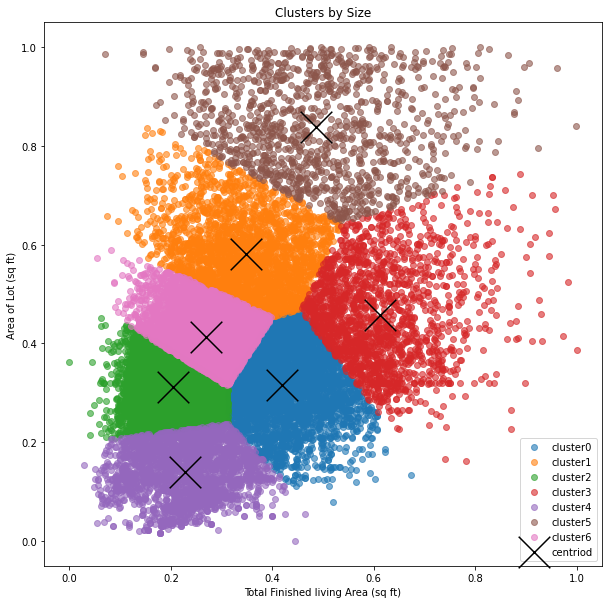

In [48]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("size_cluster"):
    plt.scatter(subset.calculatedfinishedsquarefeet, subset.lotsizesquarefeet, label="cluster" + str(cluster), alpha=.6)

centriods.plot.scatter(x="calculatedfinishedsquarefeet", y="lotsizesquarefeet", c="black", marker="x", s=1000, ax=plt.gca(), label="centriod")    
    
plt.legend()
plt.title("Clusters by Size")
plt.xlabel("Total Finished living Area (sq ft)")
plt.ylabel("Area of Lot (sq ft)")
plt.show()

In [49]:
X = train[["latitude", "longitude", "calculatedfinishedsquarefeet", "lotsizesquarefeet"]]

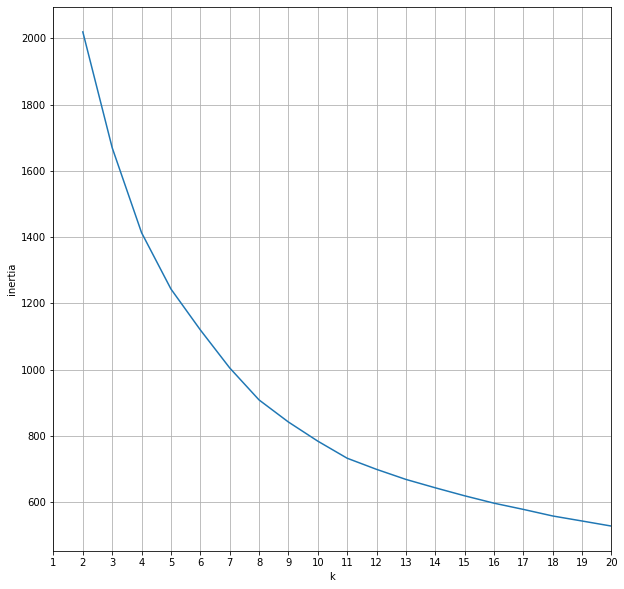

In [50]:
plt.figure(figsize=(10, 10))
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [54]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(X)
train["location_size_cluster"] = kmeans.predict(X)
train.head()

parcelid  bathroomcnt  bedroomcnt buildingqualitytypeid  \
7087   0.00871232          0.6    0.333333              0.636364   
33075   0.0244317          0.3    0.500000              0.454545   
35427   0.0128877          0.2    0.333333              0.454545   
7886    0.0233621          0.2    0.666667              0.454545   
33404   0.0118498          0.2    0.333333              0.272727   

       calculatedbathnbr  calculatedfinishedsquarefeet  fips  fullbathcnt  \
7087                 0.6                      0.522165  6037          0.6   
33075                0.3                      0.439455  6059          0.2   
35427                0.2                      0.224909  6037          0.2   
7886                 0.2                      0.274803  6059          0.2   
33404                0.2                      0.206102  6037          0.2   

       latitude  longitude  lotsizesquarefeet propertycountylandusecode  \
7087   0.565118   0.606294           0.425179                      0100   
33075  0.103840   0.918736           0.304955                       122   
35427  0.362500   0.556033           0.327198                      0100   
7886   0.271350   0.816511           0.348273                       122   
33404  0.336733   0.693832           0.315187                      0100   

      rawcensustractandblock regionidcity regionidcounty regionidzip  \
7087              0.00117839        12447           3101       96008   
33075               0.296872        17686           1286       96961   
35427             0.00743483        54722           3101       96161   
7886                0.297302        47568           1286       97004   
33404             0.00640242        46298           3101       96247   

        roomcnt unitcnt  yearbuilt  structuretaxvaluedollarcnt  \
7087   0.000000       0   0.430657                    0.696794   
33075  0.666667       0   0.700730                    0.294626   
35427  0.000000       0   0.591241                    0.179050   
7886   0.666667       0   0.613139                    0.108010   
33404  0.000000       0   0.554745                    0.163887   

       taxvaluedollarcnt assessmentyear  landtaxvaluedollarcnt  taxamount  \
7087            0.361819              0               0.155282   0.396783   
33075           0.164664              0               0.085796   0.193285   
35427           0.355638              0               0.394432   0.360944   
7886            0.285909              0               0.335843   0.296881   
33404           0.171555              0               0.157402   0.181603   

      censustractandblock  logerror transactiondate heatingorsystemdesc  \
7087          2.06058e-06  0.594238      2017-02-26             Central   
33075         0.000519124  0.598979      2017-07-14                None   
35427         1.30009e-05  0.606580      2017-07-27             Central   
7886          0.000519875  0.602900      2017-03-02                None   
33404         1.11955e-05  0.599040      2017-07-18             Central   

             propertylandusedesc              county  tax_rate  \
7087   Single Family Residential  Los Angeles County  0.477314   
33075  Single Family Residential       Orange County  0.527775   
35427  Single Family Residential  Los Angeles County  0.411598   
7886   Single Family Residential       Orange County  0.428522   
33404  Single Family Residential  Los Angeles County  0.438077   

       cluster_target  location_cluster  size_cluster  location_size_cluster  
7087                0                 0             3                      3  
33075               0                 1             0                      2  
35427               0                 4             2                      0  
7886                0                 2             6                      4  
33404               0                 2             2                      0

In [55]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

latitude  longitude  calculatedfinishedsquarefeet  lotsizesquarefeet
0  0.426120   0.631703                      0.218139           0.282099
1  0.635663   0.513244                      0.258487           0.382649
2  0.254937   0.869384                      0.517455           0.432722
3  0.604670   0.479101                      0.528160           0.456806
4  0.251070   0.853268                      0.290805           0.228896
5  0.566238   0.606631                      0.442880           0.806114
6  0.943029   0.678715                      0.326544           0.419286
7  0.656411   0.184180                      0.307819           0.372433
8  0.456280   0.786323                      0.268570           0.418511

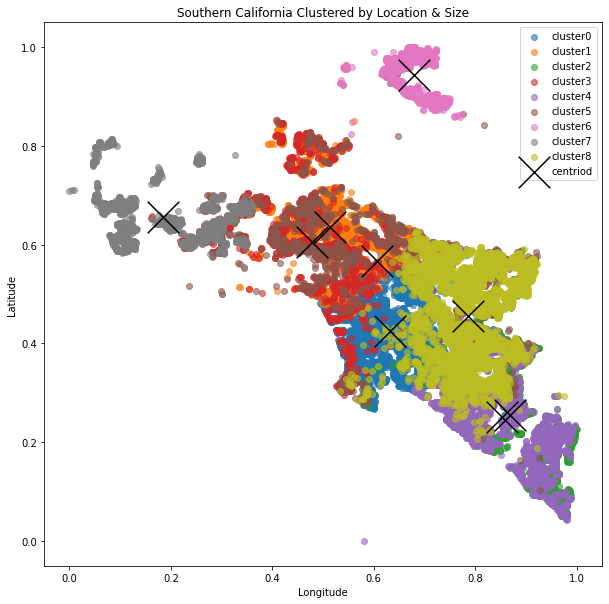

In [56]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("location_size_cluster"):
    plt.scatter(subset.longitude, subset.latitude, label="cluster" + str(cluster), alpha=.6)

centriods.plot.scatter(x="longitude", y="latitude", c="black", marker="x", s=1000, ax=plt.gca(), label="centriod")    
    
plt.legend()
plt.title("Southern California Clustered by Location & Size")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Model

In [57]:
pd.options.display.float_format = '{:.3f}'.format

In [60]:
predictions = pd.DataFrame({
    "actual_home_value": train.logerror,
    "baseline_home_value": train.logerror.mean()
})
predictions.head()

actual_home_value  baseline_home_value
7087               0.594                0.597
33075              0.599                0.597
35427              0.607                0.597
7886               0.603                0.597
33404              0.599                0.597

In [ ]:
X = train[["calculatedfinishedsquarefeet", "bedrooms", "bathrooms"]]
# target
y = train.logerror

# 1. Make the model
lm = sklearn.linear_model.LinearRegression()
# 2. Fit the model
lm.fit(X, y)
# 3. Use the model
predictions["home_value ~ square_feet + bedrooms + bathrooms"] = lm.predict(X)
predictions.head()